In [1]:
import zipfile
with zipfile.ZipFile("grasp-and-lift-eeg-detection/test.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("grasp-and-lift-eeg-detection/train.zip","r") as z:
    z.extractall(".")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('grasp-and-lift-eeg-detection/train/train/subj1_series1_data.csv')
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


In [3]:
data_events = pd.read_csv('grasp-and-lift-eeg-detection/train/train/subj1_series1_events.csv')
data_events.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


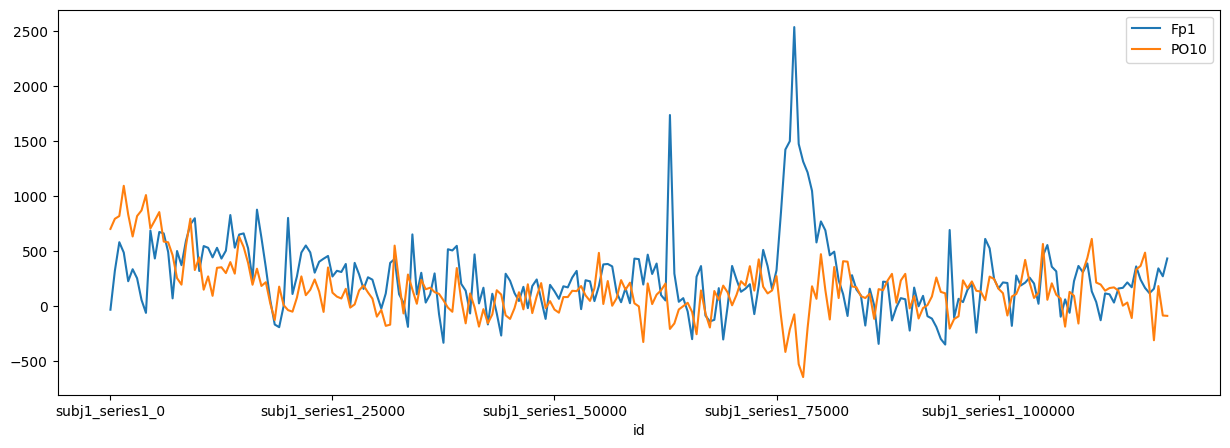

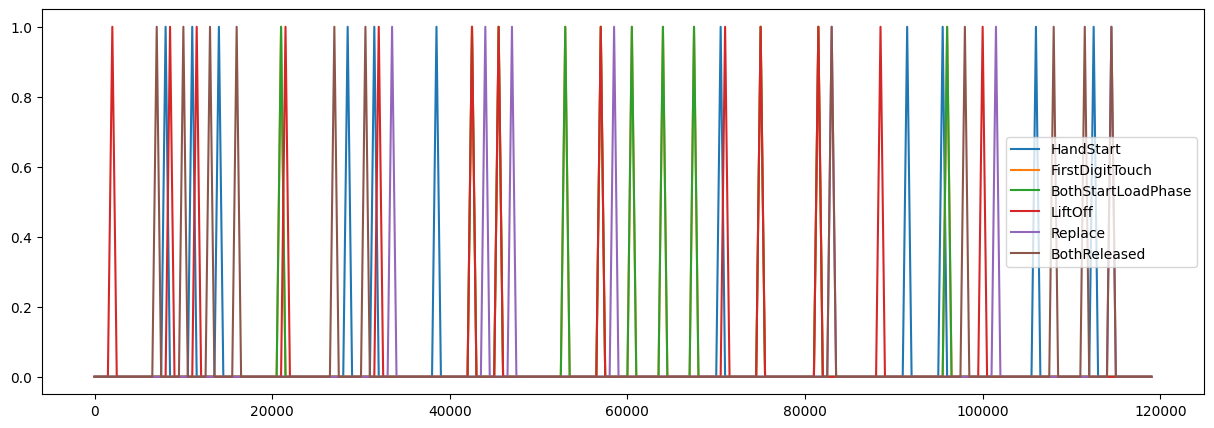

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
train_set_labels = pd.read_csv("train/subj1_series1_events.csv")
train_set_signals = pd.read_csv("train/subj1_series1_data.csv")
train_set_signals.head()
axis = plt.gca()
downSampleToShow = 500
train_set_signals[::downSampleToShow].plot(x="id", y="Fp1", ax=axis)
train_set_signals[::downSampleToShow].plot(x="id", y="PO10", ax=axis, figsize=(15,5))
train_set_labels[::downSampleToShow].plot(figsize=(15,5))
plt.show()

HandStart = red
FirstDigitTouch = purple
BothStartLoadPhase = black
LiftOff = green
Replace = yellow
BothReleased = blue


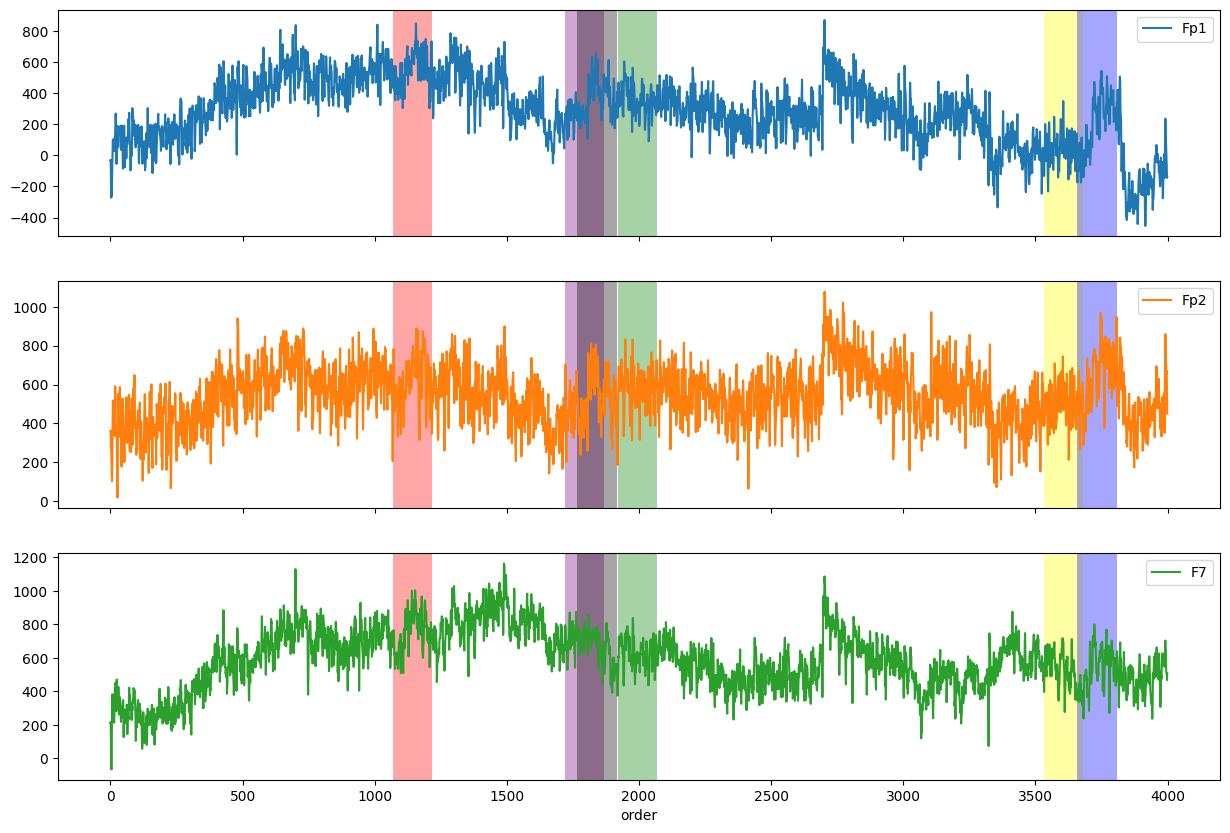

In [5]:
eeg_channels = train_set_signals.columns.drop('id')
labels = train_set_labels.columns.drop('id')
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))
train_set_complete.head()
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        i+=1
secondsToShow = 8
channelsToShow = 3
labelsToShow = 6

sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","purple","black","green", "yellow", "blue"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,10))
for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1
plt.show()

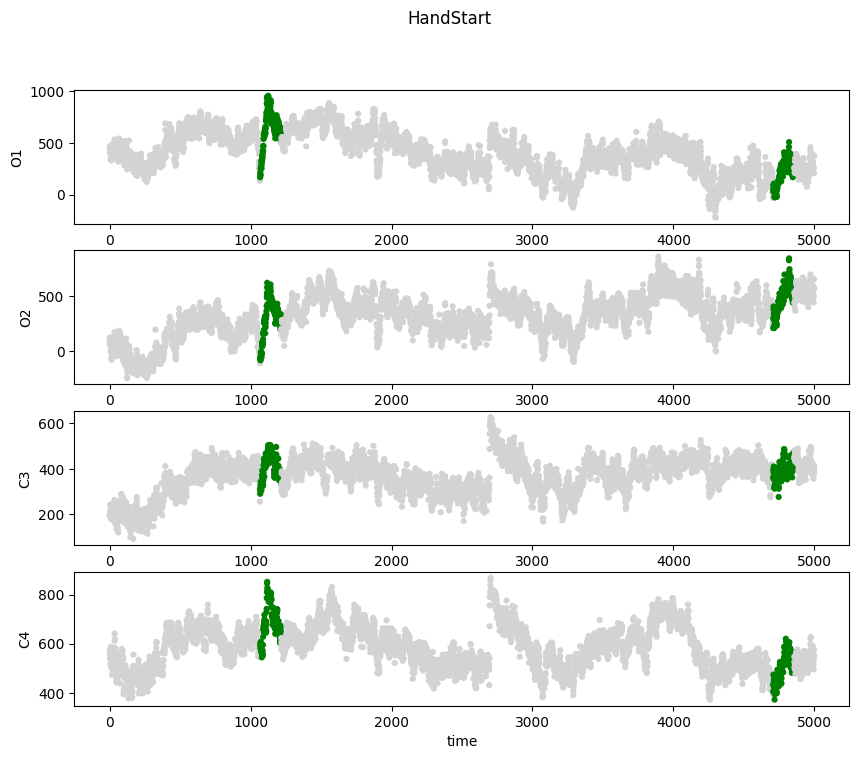

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

sub1_events_file = 'train/subj1_series1_events.csv'
sub1_data_file = 'train/subj1_series1_data.csv'

sub1_events = pd.read_csv(sub1_events_file)
sub1_data = pd.read_csv(sub1_data_file)

sub1 = pd.concat([sub1_events, sub1_data], axis = 1)
sub1["time"] = range(0, len(sub1))

sample_sub1 = sub1[sub1["time"] < 5000]

event = "HandStart"
event1 = "FirstDigitTouch"
EventColors = ["lightgrey", "green","blue"]

plot_columns = ["O1", "O2", "C3", "C4"]

fig, axes = plt.subplots(nrows=len(plot_columns), ncols=1)
fig.suptitle(event)
for (i, y) in enumerate(plot_columns):
    # Plot all the columns
    sample_sub1.plot(kind="scatter", x="time", y=y, edgecolors='none', ax=axes[i], figsize=(10,8), c=sample_sub1[event].apply(EventColors.__getitem__))

## Wavelet Denoising

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression

from glob import glob
import scipy
from scipy.signal import butter, lfilter, convolve, boxcar
from scipy.signal import freqz
from scipy.fftpack import fft, ifft
import os

from sklearn.preprocessing import StandardScaler



def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
#############function to read data###########

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep
subjects = range(1,6)
from glob import glob
import pandas as pd
ids_tot = []
pred_tot = []
X_train_butter = []
from sklearn.model_selection import train_test_split
import numpy as  np

###loop on subjects and 8 series for train data + 2 series for test data
y_raw= []
raw = []
y_rawt= []
rawt = []
for subject in subjects:
    
    ################ READ DATA ################################################
    fnames =  sorted(glob('train/subj%d_series*_data.csv' % (subject)))


#    fnames =  glob('../input/train/subj1_series1_events.csv')
#    fnames =  glob('../input/train/subj1_series1_data.csv')
    for fname in fnames:
      data,labels=prepare_data_train(fname)
      raw.append(data)
      y_raw.append(labels)

    for fname in fnames:
      with open(fname) as myfile:
        head = [next(myfile) for x in range(10)]
        

      
        
X = pd.concat(raw)
y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
X_train =np.asarray(X.astype(float))
y_train = np.asarray(y.astype(float))



from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
fs = 500.0
lowcut = 7.0
highcut = 30.0


x_train_butter=wavelet_denoising(X_train)
x_train=data_preprocess_train(x_train_butter)
splitrate=-x_train.shape[0]//5*2
xval=x_train[splitrate:splitrate//2]
yval=y_train[splitrate:splitrate//2]
xtest=x_train[splitrate//2:]
ytest=y_train[splitrate//2:]
xtrain=x_train[:splitrate]
ytrain=y_train[:splitrate]


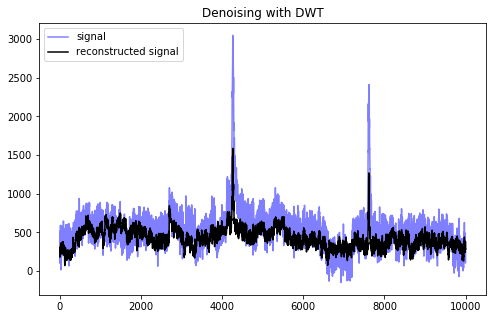

In [3]:
import pywt
import pandas as pd
import numpy as np
def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

signal=pd.read_csv('train/subj1_series1_data.csv')
signal = signal.drop("id", axis=1)
filtered = wavelet_denoising(signal, wavelet='db2', level=3)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(signal.iloc[:10000,1], label='signal', color="b", alpha=0.5,)
ax.plot(filtered[:10000,1], label='reconstructed signal',color="k")
ax.legend(loc='upper left')
ax.set_title('Denoising with DWT')
plt.show()

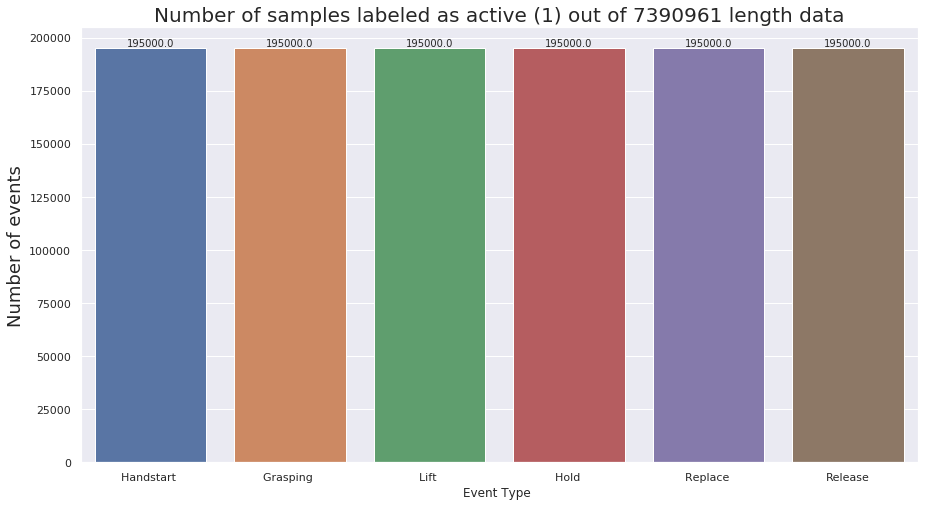

In [4]:
import seaborn as sns
ye=pd.DataFrame(y_train)

ye.columns=["Handstart ","Grasping ","Lift ","Hold ","Replace ","Release"]
categories = list(ye.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, ye.iloc[:,0:].sum().values)
plt.title("Number of samples labeled as active (1) out of {0} length data".format((ye.shape[0])),fontsize=20)

plt.ylabel('Number of events', fontsize=18)
plt.xlabel('Event Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = ye.iloc[:,0:].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf

Using TensorFlow backend.


## CNN 

In [6]:
import numpy as np
load = 1
time_steps = 1000
subsample = 50
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape = (time_steps//subsample, 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu", input_shape = (time_steps//subsample, 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (time_steps//subsample, 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(6, activation = "sigmoid"))


adam = Adam(lr = 0.0001)

model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['accuracy','mse'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 32, 64)        3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 32, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 32, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 40960)             0         
__________

In [7]:


def valgenerator():
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2],1)), yy
    

In [8]:
import time
start=time.time()
def generator(batch_size):
    while 1:
        
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1],  x_time_data.shape[2],1)), yy
        
history =model.fit_generator(generator(32), steps_per_epoch = 600, epochs = 50,validation_data=valgenerator(),
                              validation_steps=200)

print('training time taken: ',round(time.time()-start,0),'seconds')


Epoch 1/50
600/600 [==============================] - 11s 19ms/step - loss: 0.6394 - acc: 0.7373 - mean_squared_error: 0.2228 - val_loss: 0.5693 - val_acc: 0.8835 - val_mean_squared_error: 0.1893
Epoch 2/50
600/600 [==============================] - 7s 12ms/step - loss: 0.4818 - acc: 0.9609 - mean_squared_error: 0.1475 - val_loss: 0.3933 - val_acc: 0.9707 - val_mean_squared_error: 0.1078
Epoch 3/50
600/600 [==============================] - 7s 12ms/step - loss: 0.3169 - acc: 0.9746 - mean_squared_error: 0.0773 - val_loss: 0.2551 - val_acc: 0.9726 - val_mean_squared_error: 0.0555
Epoch 4/50
600/600 [==============================] - 7s 12ms/step - loss: 0.2076 - acc: 0.9742 - mean_squared_error: 0.0417 - val_loss: 0.1749 - val_acc: 0.9724 - val_mean_squared_error: 0.0344
Epoch 5/50
600/600 [==============================] - 8s 14ms/step - loss: 0.1526 - acc: 0.9741 - mean_squared_error: 0.0296 - val_loss: 0.1459 - val_acc: 0.9716 - val_mean_squared_error: 0.0295
Epoch 6/50
600/600 [====

Epoch 43/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0904 - acc: 0.9744 - mean_squared_error: 0.0220 - val_loss: 0.1128 - val_acc: 0.9728 - val_mean_squared_error: 0.0253
Epoch 44/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0871 - acc: 0.9753 - mean_squared_error: 0.0212 - val_loss: 0.1240 - val_acc: 0.9703 - val_mean_squared_error: 0.0277
Epoch 45/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0891 - acc: 0.9744 - mean_squared_error: 0.0219 - val_loss: 0.1247 - val_acc: 0.9703 - val_mean_squared_error: 0.0278
Epoch 46/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0880 - acc: 0.9747 - mean_squared_error: 0.0215 - val_loss: 0.1235 - val_acc: 0.9691 - val_mean_squared_error: 0.0282
Epoch 47/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0875 - acc: 0.9749 - mean_squared_error: 0.0215 - val_loss: 0.1162 - val_acc: 0.9710 - val_mean_squared_error: 0.0265
Epoch 48/50
600/600 

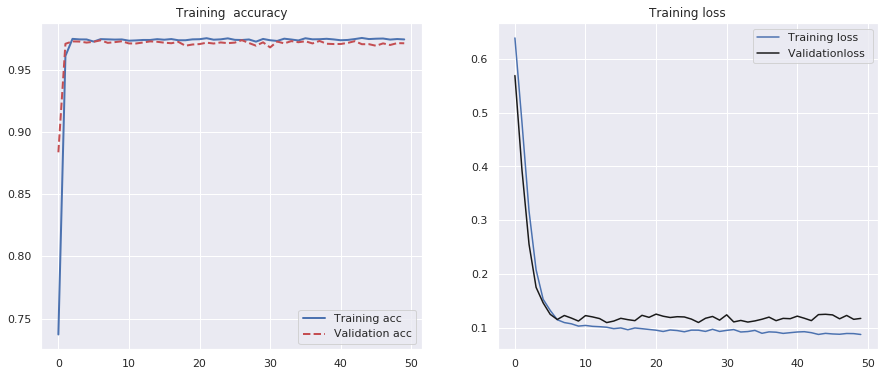

In [9]:
def plot_training_history(history):
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'k', label='Validationloss ')
    plt.title('Training loss')
    plt.legend()
 
    plt.show()
plot_training_history(history)

## Testing with unseen data

In [10]:
time_steps = 1000
subsample = 50
def val_generator():
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_steps)
            x_time_data[i] = xtest[random_index:random_index+time_steps:subsample]
            yy.append(ytest[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy

**Testing only the points where events are active** 

In [11]:
gen_data = val_generator()
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

# we need to use values.ravel to ensure the labels are sent to classifier correctly




Accuracy  0.7966666551530361


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
num_test =5000
y_score=np.zeros((num_test, 6))
y_test=np.zeros((num_test, 6))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model.predict(x_test)
    
    



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
    
print("roc_auc:",sum(roc_auc.values())/6)


roc_auc: 0.5927615557148108


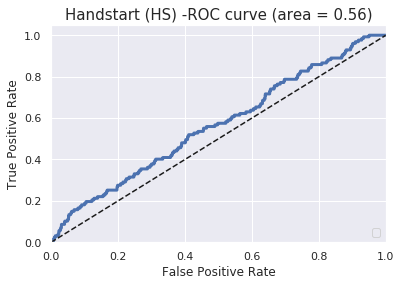

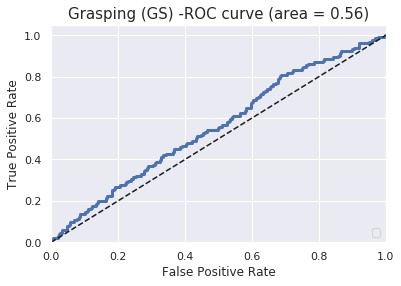

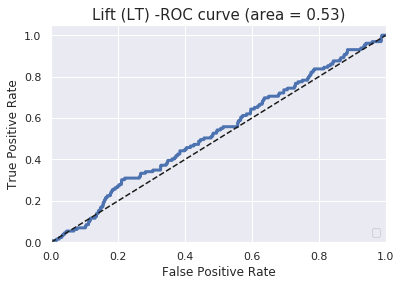

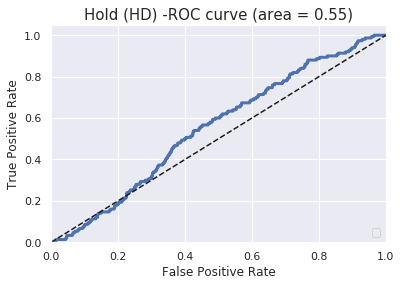

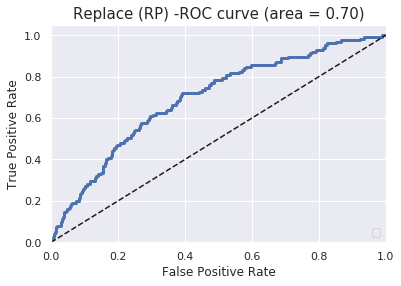

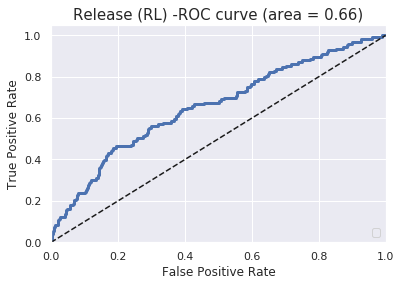

In [13]:
l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
for i in range(0,6):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()